## Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from CinePred.data.importing import import_data
from CinePred.data.preprocessing import *
from CinePred.data.featuring import *
from CinePred.pipeline import *
from CinePred.baseline import *

from CinePred import pipeline
from CinePred import baseline
from CinePred import new_model
from CinePred.new_model import *



from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_validate
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import FunctionTransformer, RobustScaler, OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

from sklearn import set_config; set_config(display='diagram')

import datetime
sns.set(rc={'figure.figsize':(16,8)})
pd.set_option('display.max_columns', None)

%load_ext autoreload
%autoreload 2

## Import Data

In [170]:
df_preproc = import_data(link = '../raw_data/preprocessed.csv')
df_preproc.head(2)

,worlwide_gross_income,year,duration,budget,production_company,director,writer,shifted,nb_movies_actor1,nb_movies_actor2,nb_movies_actor3,last income,imdb_title_id,actors,description,avg_vote,country,date_sin,date_cos,Action,Biography,Thriller,Crime,Drama,Adventure,Romance,Western,Documentary,Musical,Film-Noir,Fantasy,Mystery,Sport,History,War,Horror,Family,Music,Sci-Fi,Animation,Comedy,Nb_actuals_movie_production_company,Nb_actuals_movie_directors,Nb_actuals_movie_writers,title
0,4.476463,2012,95,2.304875,Elixir Entretenimento,Lúcia Murat,"Tatiana Salem Levy, Lúcia Murat",0,1,1.0,1.0,0.0,tt2476186,"Clarisse Abujamra, Otávio Augusto, Eduardo Cra...",A group of friends who resisted Brazilian dict...,6.2,"Brazil, Argentina",-0.5,0.866025,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,1,Memories They Told Me
1,4.908817,2018,132,2.761312,Caos Calmo Filmes,"Sérgio Graciano, Manuel Pureza","Ricardo Oliveira, Manuel Pureza",0,1,1.0,1.0,0.0,tt8128618,"Samuel Alves, Tomás Alves, Álvaro Aragonez, Ke...","Threatened by a fascist plot, the Portuguese g...",3.3,Portugal,-0.5,-0.866025,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,Blood Lines


In [171]:
def test(director,year,main_actor,second_actor,third_actor,writer,production_company,date_published,genre,duration,budget,title =''):

    #----   Init Dataframe ----#
    df=pd.DataFrame({'year':[year]})
    df['year'] = year
    df['duration'] = duration
    df['budget'] = budget*1000000
    df['genre'] = genre
    df['director'] = director
    df['writer'] = writer
    df['production_company'] = production_company
    df['actors'] = f'{main_actor}, {second_actor}, {third_actor}'
    df['date_published'] = date_published
    
    #----   preproc   ----#
    df['year'] = convert_to_int(df[['year']])
    df['duration'] = convert_to_int(df[['duration']])
    df['budget'] = log_transformation(df[['budget']])

    actors_1 = df_preproc[['shifted','actors']][df_preproc[['shifted','actors']]['actors'].str.contains(main_actor)].max()['shifted']
    actors_2 = df_preproc[['shifted','actors']][df_preproc[['shifted','actors']]['actors'].str.contains(second_actor)].max()['shifted']
    actors_3 = df_preproc[['shifted','actors']][df_preproc[['shifted','actors']]['actors'].str.contains(third_actor)].max()['shifted']
    shifted = actors_1 + actors_2 + actors_3
    df['shifted'] = shifted
    print(shifted)
    
    
    df['nb_movies_actor1'] = int(df_preproc[df_preproc['actors'].str.contains(main_actor)][['year','nb_movies_actor1']].sort_values(by='year').iloc[-5:]['nb_movies_actor1'].mean())
    df['nb_movies_actor2'] = int(df_preproc[df_preproc['actors'].str.contains(second_actor)][['year','nb_movies_actor1']].sort_values(by='year').iloc[-5:]['nb_movies_actor1'].mean())
    df['nb_movies_actor3'] = int(df_preproc[df_preproc['actors'].str.contains(third_actor)][['year','nb_movies_actor1']].sort_values(by='year').iloc[-5:]['nb_movies_actor1'].mean())

    
    last_income_actor1 = df_preproc[df_preproc['actors'].str.contains(main_actor)][['year','last income']].sort_values(by='year').iloc[-1]['last income']
    last_income_actor2 = df_preproc[df_preproc['actors'].str.contains(second_actor)][['year','last income']].sort_values(by='year').iloc[-1]['last income']
    last_income_actor3 = df_preproc[df_preproc['actors'].str.contains(third_actor)][['year','last income']].sort_values(by='year').iloc[-1]['last income']
    df['last income'] =  np.mean([last_income_actor1,last_income_actor2,last_income_actor3])
    
    df['date_published'] = convert_to_date(df[['date_published']])
    df['date_sin'] = add_sin_features(df[['date_published']])
    df['date_cos'] = add_cos_features(df[['date_published']])
    df.drop(columns='date_published', inplace=True)

    ohe = GenreOHE()
    ohe.fit(df) # la colonne 'genre' est spécifié dans la classe
    df = ohe.transform(df)
    
    df['Nb_actuals_movie_production_company'] = df_preproc[['Nb_actuals_movie_production_company','production_company']][df_preproc[['Nb_actuals_movie_production_company','production_company']]['production_company'].str.contains(production_company)].max()['Nb_actuals_movie_production_company']
    df['Nb_actuals_movie_directors'] = df_preproc[['Nb_actuals_movie_directors','director']][df_preproc[['Nb_actuals_movie_directors','director']]['director'].str.contains(director)].max()['Nb_actuals_movie_directors']
    df['Nb_actuals_movie_writers'] = df_preproc[['Nb_actuals_movie_writers','writer']][df_preproc[['Nb_actuals_movie_writers','writer']]['writer'].str.contains(writer)].max()['Nb_actuals_movie_writers']

    
    df = df.drop(columns=['actors'])
    
    df = df.drop(columns=['production_company','director','writer'])
    
    #----   Prediction   ----#
    model = load_model("model.joblib")
    result = predict_fromX(model,df)
    
    return result


In [172]:
test(
    director='Martin Scorcese',
    year=2022,
    main_actor='Will Smith',#Brad Pitt',
    second_actor='Johnny Depp',
    third_actor='Will Smith',
    writer='Woody Allen',
    production_company='Walt Disney Pictures',
    date_published='2022-01-01',
    genre='Drama',
    duration=100,
    budget=272.70
)

#252 013 849.34471068
#252 013 849.34471068

20


419511244.9825506

In [14]:
df_preproc.head(1).drop(columns=['worlwide_gross_income','production_company','director','writer'])

,year,duration,budget,shifted,nb_movies_actor1,nb_movies_actor2,nb_movies_actor3,last income,imdb_title_id,actors,description,avg_vote,country,date_sin,date_cos,Action,Biography,Thriller,Crime,Drama,Adventure,Romance,Western,Documentary,Musical,Film-Noir,Fantasy,Mystery,Sport,History,War,Horror,Family,Music,Sci-Fi,Animation,Comedy,Nb_actuals_movie_production_company,Nb_actuals_movie_directors,Nb_actuals_movie_writers,title
0,2012,95,2.304875,0,1,1.0,1.0,0.0,tt2476186,"Clarisse Abujamra, Otávio Augusto, Eduardo Cra...",A group of friends who resisted Brazilian dict...,6.2,"Brazil, Argentina",-0.5,0.866025,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,1,Memories They Told Me


In [175]:
df_preproc = import_data(link = '../raw_data/preprocessed.csv')
df_preproc = df_preproc.drop(columns=['production_company', 'director', 'writer'])
df_preproc = df_preproc.drop(columns=['imdb_title_id','actors','description','avg_vote','country','title'])

model = get_fitted_model(df_preproc)

print("----- SAVE MODEL ------")
save_model(model, "model.joblib")

mae = 0.58
----- SAVE MODEL ------


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

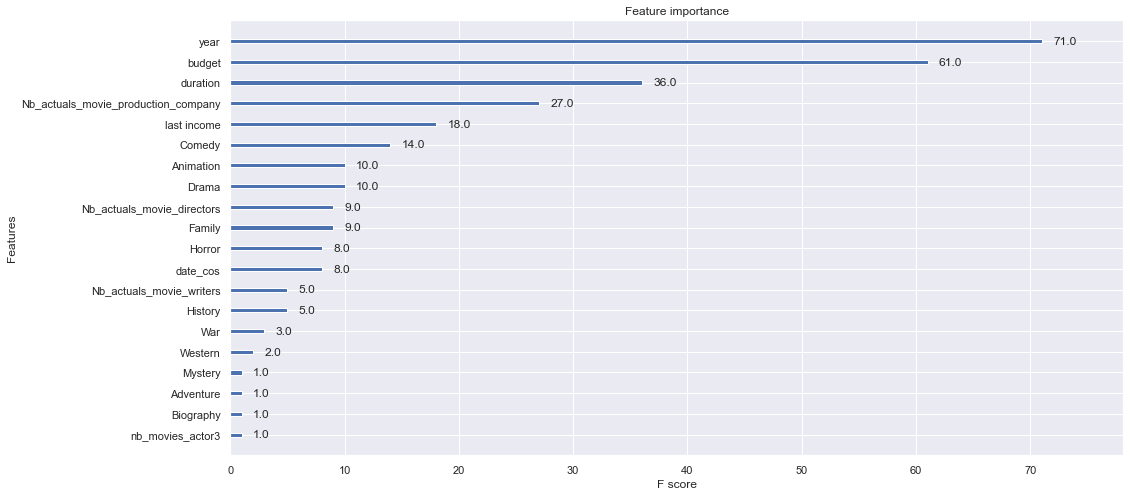

In [202]:
from xgboost import plot_importance

plot_importance(model,importance_type='weight')

In [192]:
X_test_1 = df_preproc.head(randInt()).drop(columns=['worlwide_gross_income'])
X_test_1

,year,duration,budget,shifted,nb_movies_actor1,nb_movies_actor2,nb_movies_actor3,last income,date_sin,date_cos,Action,Biography,Thriller,Crime,Drama,Adventure,Romance,Western,Documentary,Musical,Film-Noir,Fantasy,Mystery,Sport,History,War,Horror,Family,Music,Sci-Fi,Animation,Comedy,Nb_actuals_movie_production_company,Nb_actuals_movie_directors,Nb_actuals_movie_writers
0,2012,95,2.304875,0,1,1.0,1.0,0.0,-0.5,0.866025,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,1


In [200]:
X_test_2 = X_test_1.copy()
X_test_2['shifted'] = 3_000_000_000
X_test_2

,year,duration,budget,shifted,nb_movies_actor1,nb_movies_actor2,nb_movies_actor3,last income,date_sin,date_cos,Action,Biography,Thriller,Crime,Drama,Adventure,Romance,Western,Documentary,Musical,Film-Noir,Fantasy,Mystery,Sport,History,War,Horror,Family,Music,Sci-Fi,Animation,Comedy,Nb_actuals_movie_production_company,Nb_actuals_movie_directors,Nb_actuals_movie_writers
0,2012,95,2.304875,3000000000,1,1.0,1.0,0.0,-0.5,0.866025,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,1


In [201]:
print("----- LOAD MODEL ------")
model = load_model("model.joblib")

print("----- PREDICT MODEL ------")
prediction1 = predict_fromX(model, X_test_1)
prediction2 = predict_fromX(model, X_test_2)

print(prediction1)
print(prediction2)

----- LOAD MODEL ------
----- PREDICT MODEL ------
1526461.2344807005
1526461.2344807005


In [ ]:
df_preproc = df_preproc.drop(columns=['production_company', 'director', 'writer'])
df_preproc = df_preproc.drop(columns=['imdb_title_id','actors','description','avg_vote','country','title'])
df_preproc.head(1)
  

## Cleaning and creating X and y

In [ ]:
df = import_data(path = 'raw_data/IMDb movies.csv')

# Prepare
print("----- CLEAN DATA ------")
df_preproc = preproc(df)

print("----- GET FITTED MODEL ------")
model = get_fitted_model(df_preproc)

print("----- SAVE MODEL ------")
save_model(model, "model.joblib")

print("----- LOAD MODEL ------")
model = load_model("model.joblib")

print("----- PREDICT MODEL ------")
prediction = predict_fromX(
model,df_preproc.head(1).drop(columns='worlwide_gross_income'))
print(prediction)

In [ ]:
# Plot Y distribution

sns.set(rc={'figure.figsize':(16,8)})
sns.histplot(df_sample['worlwide_gross_income'], kde=True, edgecolor='w')

In [ ]:
df_sample['worlwide_gross_income'] = log_transformation(df_sample[['worlwide_gross_income']])
sns.histplot(df_sample['worlwide_gross_income'], kde=True, edgecolor='w')

In [ ]:
ax = sns.scatterplot(x=df_sample['budget_log'],y=df_sample['worlwide_gross_income'])

## Baseline

In [ ]:
X_baseline = df_sample[[
        'budget',
        'duration',
        'year',
        'date_published',
    ]]
y_baseline = df_sample['worlwide_gross_income']
model_baseline = baseline.create_pipeline()

In [ ]:
model_baseline = model_baseline.fit(X_baseline,y_baseline)

In [ ]:
predict_y_baseline = model_baseline.predict(X_baseline)
residuals_baseline = predict_y_baseline - y_baseline

In [ ]:
ax = sns.scatterplot(x=y_baseline,y=residuals_baseline, hue=df_sample['budget'])
ax.set(xlabel='income', ylabel='residuals')

## Pipeline v1

In [ ]:
# Creating X and y
X_pipeline_v1 = df_sample[[
    'budget',
    'genre', 
    'duration', 
    'year', 
    'date_published',
    'production_company', 
    'writer', 
    'director'
    ]]
y_pipeline_v1 = df_sample['worlwide_gross_income']



In [ ]:
model_pipeline_v1 = pipeline.create_pipeline()
model_pipeline_v1 = model_pipeline_v1.fit(X_pipeline_v1,y_pipeline_v1)
predict_y_pipeline_v1 = model_pipeline_v1.predict(X_pipeline_v1)

In [ ]:
residuals_pipeline_v1 = predict_y_pipeline_v1 - y_pipeline_v1
ax = sns.scatterplot(x=X_pipeline_v1['budget'],y=residuals_pipeline_v1, hue=df_sample['budget'])
ax.set(xlabel='budget', ylabel='residuals pipeline v1')

In [ ]:
ax = sns.histplot(x=X_pipeline_v1['budget'])
ax.set(xlabel='budget', ylabel='residuals pipeline v1')

## Pipeline v2

In [ ]:
df_sample = import_data('../raw_data/IMDb movies.csv')
#df_sample = new_model.preproc(df_sample)

In [ ]:
df_sample.head(1)

In [ ]:
print("----- IMPORT DATA ------")
df = import_data('../raw_data/IMDb movies.csv')

In [ ]:
# Prepare
print("----- CLEAN DATA ------")
df_proc = preproc(df)

In [ ]:
print("----- GET FITTED MODEL ------")
model = get_fitted_model(df_proc)

In [ ]:
print("----- SAVE MODEL ------")
save_model(model, "model.joblib")

In [ ]:
print("----- LOAD MODEL ------")
model = load_model("model.joblib")

In [ ]:
print("----- PREDICT MODEL ------")
prediction = predict_fromX(model, df_proc.head(1).drop(columns='worlwide_gross_income'))
print(prediction[0])